# BNL Development Notebook

This notebook is for developing and testing the BNL package.


In [64]:
%load_ext autoreload
%autoreload 2

import bnl

# R2_BUCKET_PUBLIC_URL = "https://pub-05e404c031184ec4bbf69b0c2321b98e.r2.dev"

# slm_ds = bnl.data.Dataset(manifest_path=f"{R2_BUCKET_PUBLIC_URL}/manifest_cloud_boolean.csv")
slm_ds = bnl.data.Dataset(manifest_path="~/data/salami/metadata.csv")
# slm_ds = bnl.data.Dataset()
track = slm_ds[8]
est = track.load_annotation("adobe-mu1gamma1")
ref = track.load_annotation("reference")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
track.info

{'track_id': '8',
 'annotation_adobe-mu1gamma1_path': PosixPath('/Users/tomxi/data/salami/adobe/def_mu_0.1_gamma_0.1/8.mp3.msdclasscsnmagic.json'),
 'annotation_adobe-mu1gamma9_path': PosixPath('/Users/tomxi/data/salami/adobe/def_mu_0.1_gamma_0.9/8.mp3.msdclasscsnmagic.json'),
 'annotation_adobe-mu5gamma5_path': PosixPath('/Users/tomxi/data/salami/adobe/def_mu_0.5_gamma_0.5/8.mp3.msdclasscsnmagic.json'),
 'annotation_reference_path': PosixPath('/Users/tomxi/data/salami/jams/8.jams'),
 'audio_mp3_path': PosixPath('/Users/tomxi/data/salami/audio/8.mp3')}

track_id                             8
has_annotation_adobe-mu1gamma1    True
has_annotation_adobe-mu1gamma9    True
has_annotation_adobe-mu5gamma5    True
has_annotation_reference          True
has_audio_mp3                     True
Name: 8, dtype: object

In [34]:
ref.plot().show()
est.plot().show()

In [36]:
track.ests

{'mu1gamma1': TS(B(0.0)-B(227.73302), adobe-mu1gamma1),
 'mu1gamma9': TS(B(0.0)-B(227.73302), adobe-mu1gamma9),
 'mu5gamma5': TS(B(0.0)-B(227.73302), adobe-mu5gamma5)}

In [37]:
track.info

{'track_id': '8',
 'annotation_adobe-mu1gamma1_path': PosixPath('/Users/tomxi/data/salami/adobe/def_mu_0.1_gamma_0.1/8.mp3.msdclasscsnmagic.json'),
 'annotation_adobe-mu1gamma9_path': PosixPath('/Users/tomxi/data/salami/adobe/def_mu_0.1_gamma_0.9/8.mp3.msdclasscsnmagic.json'),
 'annotation_adobe-mu5gamma5_path': PosixPath('/Users/tomxi/data/salami/adobe/def_mu_0.5_gamma_0.5/8.mp3.msdclasscsnmagic.json'),
 'annotation_reference_path': PosixPath('/Users/tomxi/data/salami/jams/8.jams'),
 'audio_mp3_path': PosixPath('/Users/tomxi/data/salami/audio/8.mp3')}

In [55]:
[attr for attr in dir(track) if not attr.startswith("__")]

['_ests',
 '_info',
 '_jam',
 '_load_jams_anno',
 '_load_json',
 '_refs',
 'dataset',
 'ests',
 'info',
 'jam',
 'load_annotation',
 'manifest_row',
 'refs',
 'track_id']

In [53]:
for ref in track.refs.values():
    ref.plot().show()

In [23]:
ref.plot().show()
est.plot().show()


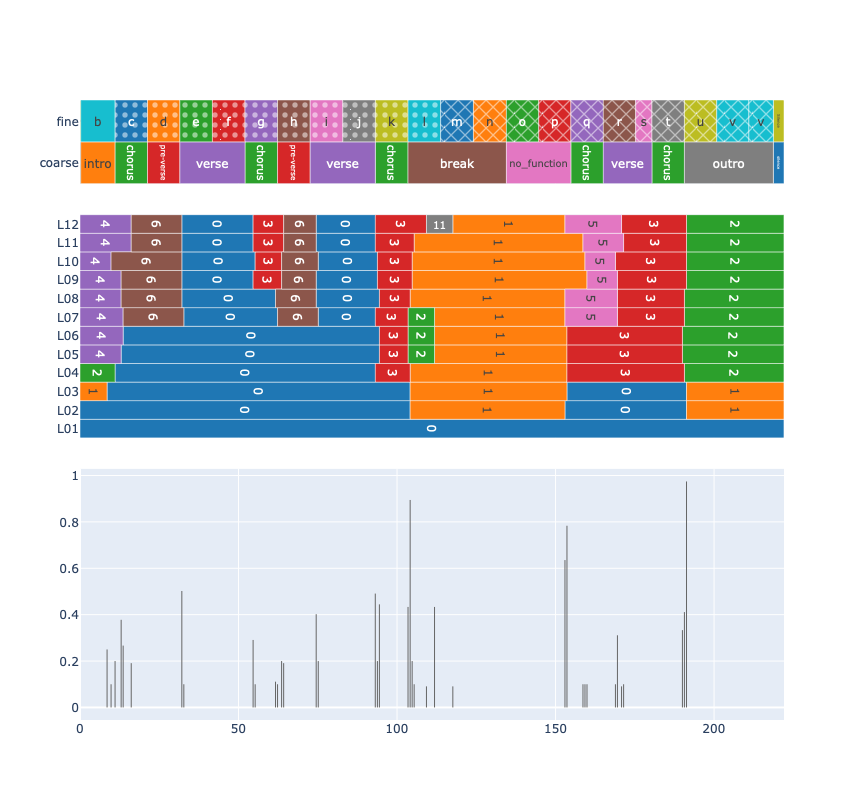

In [6]:
# Put the two figures top and bottom with shared x-axis
from plotly.subplots import make_subplots

track = slm_ds[11]
est = track.load_annotation("adobe-mu1gamma9")
ref = track.load_annotation("reference")
fig_est = est.plot(colorscale="D3")
fig_ref = ref.plot(colorscale="D3")

fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.15, 0.4, 0.45],
)

for trace in fig_ref.data:
    fig.add_trace(trace, row=1, col=1)
for trace in fig_est.data:
    fig.add_trace(trace, row=2, col=1)
for trace in est.to_contour('prob').plot().data:
    fig.add_trace(trace, row=3, col=1)

fig.update_layout(
    xaxis3_range=[ref.start.time, ref.end.time],
    barmode="overlay",
    yaxis1=dict(
        categoryorder="array",
        categoryarray=[layer.name for layer in reversed(est)],
    ),
    yaxis2=dict(
        categoryorder="array",
        categoryarray=[layer.name for layer in reversed(ref)],
    ),
)
fig.update_layout(height=800, width=650, legend_visible=False)
fig.show()

In [12]:
(est.to_contour('prob')
 .plot()
 .update_layout(height=300, width=750)
 .show()
)